<a href="https://colab.research.google.com/github/MichelleAppel/distribution-aware-image-to-image-translation/blob/master/toy_example/fly_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os.path
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms

from itertools import chain

import numpy as np
import math
import itertools
import random

from scipy import signal

import matplotlib.pyplot as plt

import zipfile

# Fly data experiment

Todo:
*   Use annotations somehow
*   Improve networks: AE and weightnet are not tailored for 128x128 images

## The Dataset

In [2]:
zipdataroot_A = '/content/drive/MyDrive/fly_data_ubc_2021/generated_fly_with_annotation.zip'
zipdataroot_B = '/content/drive/MyDrive/fly_data_ubc_2021/real_fly.zip'

dataroot_A = '/content/flydata/data_A'
dataroot_B = '/content/flydata/data_B'

if not os.path.exists(dataroot_A):
  with zipfile.ZipFile(zipdataroot_A, 'r') as zip_ref:
      zip_ref.extractall(dataroot_A)

if not os.path.exists(dataroot_B):
  with zipfile.ZipFile(zipdataroot_B, 'r') as zip_ref:
      zip_ref.extractall(dataroot_B)

In [3]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname) and not fname.endswith('real_A.png') and not fname.endswith('render_pose.png'):
                path = os.path.join(root, fname)
                images.append(path)

    return images

In [24]:
def __adjust(img):
    ow, oh = img.size

    # the size needs to be a multiple of this number,
    # because going through generator network may change img size
    # and eventually cause size mismatch error
    mult = 4
    if ow % mult == 0 and oh % mult == 0:
        return img
    w = (ow - 1) // mult
    w = (w + 1) * mult
    h = (oh - 1) // mult
    h = (h + 1) * mult

    return img.resize((w, h), Image.BICUBIC)

def normalize(img):
  return img * 2 - 1


def get_transform():
    loadSize = 128
    osize = [loadSize, loadSize]

    transform_list = []
    transform_list.append(transforms.Lambda(
            lambda img: __adjust(img)))
    
    transform_list.append(transforms.Resize(osize, Image.BICUBIC))  
    transform_list += [transforms.ToTensor()]
                      #  transforms.Normalize((0.5, 0.5, 0.5),
                      #                       (0.5, 0.5, 0.5))]
    transform_list.append(transforms.Lambda(
            lambda img: normalize(img)))
    
    return transforms.Compose(transform_list)

In [25]:
class FlyDataset(Dataset):
  def __init__(self):
    self.dataroot_A = dataroot_A
    self.dataroot_B = dataroot_B

    self.A_paths = make_dataset(self.dataroot_A)
    self.B_paths = make_dataset(self.dataroot_B)

    self.A_size = len(self.A_paths)
    self.B_size = len(self.B_paths)

    self.dir_len = len(self.dataroot_A) + 1

    self.transform = get_transform()

  def __getitem__(self, index):
      A_path = self.A_paths[index % self.A_size]
      A_name = A_path[self.dir_len:]
      
      index_B = random.randint(0, self.B_size - 1)
          
      B_path = self.B_paths[index_B]

      A_img = Image.open(A_path).convert('RGB')
      B_img = Image.open(B_path).convert('RGB')

      A = self.transform(A_img)
      B = self.transform(B_img)

      return {'A': A, 'B': B}

  def __len__(self):
    return max(self.A_size, self.B_size)

In [26]:
dataset = FlyDataset()

batch_size = 32
dataloader = DataLoader(dataset, batch_size, shuffle=True)

In [27]:
def visualize(img):
  plt.imshow((img.permute(1,2,0) + 1) / 2)
  plt.show()

## The Networks

TODO: improve networks

In [31]:
class VAE(nn.Module):
    def __init__(self, zsize, layer_count=5, channels=3):
        super(VAE, self).__init__()

        d = 128
        self.d = d
        self.zsize = zsize

        self.layer_count = layer_count

        mul = 1
        inputs = channels
        for i in range(self.layer_count):
            setattr(self, "conv%d" % (i + 1), nn.Conv2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "conv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul *= 2

        self.d_max = inputs

        self.fc1 = nn.Linear(inputs * 4 * 4, zsize)
        self.fc2 = nn.Linear(inputs * 4 * 4, zsize)

        self.d1 = nn.Linear(zsize, inputs * 4 * 4)

        mul = inputs // d // 2

        for i in range(1, self.layer_count):
            setattr(self, "deconv%d" % (i + 1), nn.ConvTranspose2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "deconv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul //= 2

        setattr(self, "deconv%d" % (self.layer_count + 1), nn.ConvTranspose2d(inputs, channels, 4, 2, 1))

    def encode(self, x):
        for i in range(self.layer_count):
            x = F.relu(getattr(self, "conv%d_bn" % (i + 1))(getattr(self, "conv%d" % (i + 1))(x)))

        x = x.view(x.shape[0], self.d_max * 4 * 4)
        h1 = self.fc1(x)
        h2 = self.fc2(x)
        return h1, h2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, x):
        x = x.view(x.shape[0], self.zsize)
        x = self.d1(x)
        x = x.view(x.shape[0], self.d_max, 4, 4)
        #x = self.deconv1_bn(x)
        x = F.leaky_relu(x, 0.2)

        for i in range(1, self.layer_count):
            x = F.leaky_relu(getattr(self, "deconv%d_bn" % (i + 1))(getattr(self, "deconv%d" % (i + 1))(x)), 0.2)

        x = F.tanh(getattr(self, "deconv%d" % (self.layer_count + 1))(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        mu = mu.squeeze()
        logvar = logvar.squeeze()
        z = self.reparameterize(mu, logvar)
        return self.decode(z.view(-1, self.zsize, 1, 1)), mu, logvar

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)


def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

## Training

In [32]:
def loss_function(recon_x, x, mu, logvar):
    BCE = torch.mean((recon_x - x)**2)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(torch.mean(1 + logvar - mu.pow(2) - logvar.exp(), 1))
    return BCE, KLD * 0.1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 0 step 0 loss_re_A 0.9935580492019653 loss_kl_A 0.012558328919112682 loss_re_B 1.0045360326766968 loss_kl_B 0.01239632535725832


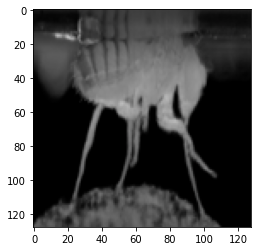

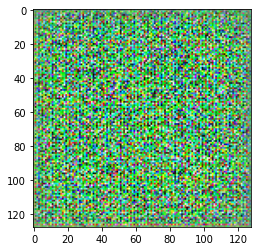

epoch 0 step 10 loss_re_A 0.400924414396286 loss_kl_A 0.13565203547477722 loss_re_B 0.40333837270736694 loss_kl_B 0.13538746535778046
epoch 0 step 20 loss_re_A 0.2242320030927658 loss_kl_A 0.03952474519610405 loss_re_B 0.22740331292152405 loss_kl_B 0.03958803042769432
epoch 0 step 30 loss_re_A 0.24951481819152832 loss_kl_A 0.030605962499976158 loss_re_B 0.2486005425453186 loss_kl_B 0.030886445194482803
epoch 0 step 40 loss_re_A 0.17485961318016052 loss_kl_A 0.23843340575695038 loss_re_B 0.1776193380355835 loss_kl_B 0.23804950714111328
epoch 1 step 0 loss_re_A 0.17343026399612427 loss_kl_A 0.24051561951637268 loss_re_B 0.17813244462013245 loss_kl_B 0.24070489406585693


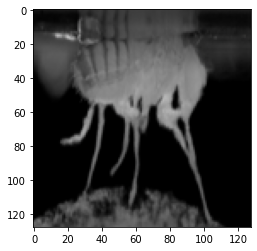

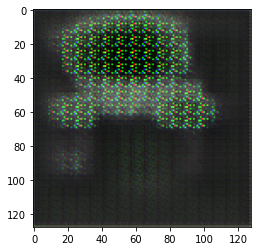

epoch 1 step 10 loss_re_A 0.1983182430267334 loss_kl_A 0.02242164872586727 loss_re_B 0.21631333231925964 loss_kl_B 0.022415118291974068
epoch 1 step 20 loss_re_A 0.12341265380382538 loss_kl_A 0.09825704246759415 loss_re_B 0.12414686381816864 loss_kl_B 0.09891057014465332
epoch 1 step 30 loss_re_A 0.07195283472537994 loss_kl_A 0.07161247730255127 loss_re_B 0.07575713098049164 loss_kl_B 0.07088097184896469
epoch 1 step 40 loss_re_A 0.06630140542984009 loss_kl_A 0.12805601954460144 loss_re_B 0.07080432772636414 loss_kl_B 0.12892405688762665
epoch 2 step 0 loss_re_A 0.12546275556087494 loss_kl_A 0.022950073704123497 loss_re_B 0.11970444768667221 loss_kl_B 0.02294805459678173


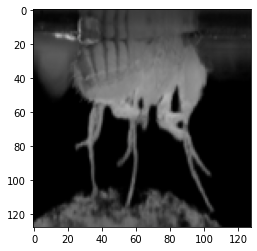

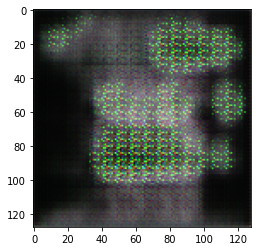

epoch 2 step 10 loss_re_A 0.05805496126413345 loss_kl_A 0.018372435122728348 loss_re_B 0.061700593680143356 loss_kl_B 0.01866014674305916
epoch 2 step 20 loss_re_A 0.07177835702896118 loss_kl_A 0.03872161731123924 loss_re_B 0.07721125334501266 loss_kl_B 0.03876335918903351
epoch 2 step 30 loss_re_A 0.04329664632678032 loss_kl_A 0.010365482419729233 loss_re_B 0.04908481240272522 loss_kl_B 0.010713756084442139
epoch 2 step 40 loss_re_A 0.045441918075084686 loss_kl_A 0.17321324348449707 loss_re_B 0.051518917083740234 loss_kl_B 0.17309819161891937
epoch 3 step 0 loss_re_A 0.04045183211565018 loss_kl_A 0.03961985185742378 loss_re_B 0.047261349856853485 loss_kl_B 0.0397309772670269


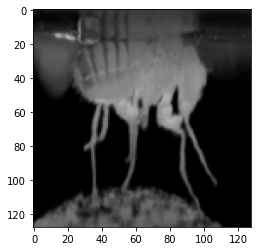

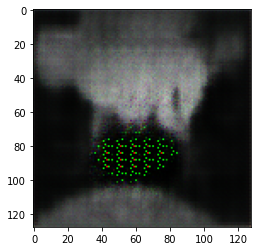

epoch 3 step 10 loss_re_A 0.07653972506523132 loss_kl_A 0.10749702900648117 loss_re_B 0.07982045412063599 loss_kl_B 0.10446470975875854
epoch 3 step 20 loss_re_A 0.07693947851657867 loss_kl_A 0.01858781836926937 loss_re_B 0.08081452548503876 loss_kl_B 0.01901601441204548
epoch 3 step 30 loss_re_A 0.0314418189227581 loss_kl_A 0.011754042468965054 loss_re_B 0.04051872715353966 loss_kl_B 0.011886384338140488
epoch 3 step 40 loss_re_A 0.02866435796022415 loss_kl_A 0.006062889005988836 loss_re_B 0.037130389362573624 loss_kl_B 0.006315506994724274
epoch 4 step 0 loss_re_A 0.03583882004022598 loss_kl_A 0.002099250676110387 loss_re_B 0.04026828706264496 loss_kl_B 0.0022544299717992544


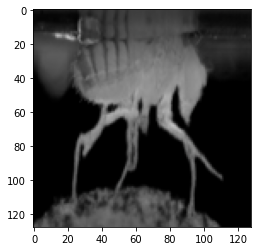

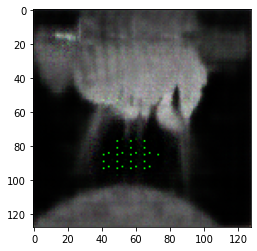

epoch 4 step 10 loss_re_A 0.026628803461790085 loss_kl_A 0.04706946387887001 loss_re_B 0.033477794378995895 loss_kl_B 0.04740117862820625
epoch 4 step 20 loss_re_A 0.027077890932559967 loss_kl_A 0.0014960768166929483 loss_re_B 0.033202022314071655 loss_kl_B 0.0016288704937323928
epoch 4 step 30 loss_re_A 0.025966163724660873 loss_kl_A 0.0011424965923652053 loss_re_B 0.034597840160131454 loss_kl_B 0.0013232209021225572
epoch 4 step 40 loss_re_A 0.02495623007416725 loss_kl_A 0.001727687194943428 loss_re_B 0.032308775931596756 loss_kl_B 0.0017978206742554903
epoch 5 step 0 loss_re_A 0.024252139031887054 loss_kl_A 0.0008596236002631485 loss_re_B 0.03228633105754852 loss_kl_B 0.0009520130115561187


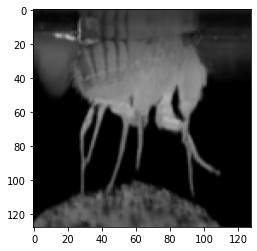

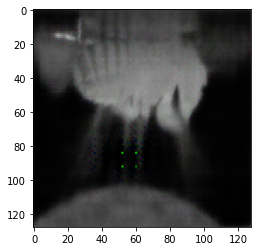

epoch 5 step 10 loss_re_A 0.023111825808882713 loss_kl_A 0.017039695754647255 loss_re_B 0.031091708689928055 loss_kl_B 0.01710461638867855
epoch 5 step 20 loss_re_A 0.025022372603416443 loss_kl_A 0.0010298086563125253 loss_re_B 0.031113510951399803 loss_kl_B 0.001164894551038742
epoch 5 step 30 loss_re_A 0.023798350244760513 loss_kl_A 0.001951809274032712 loss_re_B 0.030135229229927063 loss_kl_B 0.0019847084768116474
epoch 5 step 40 loss_re_A 0.02290274016559124 loss_kl_A 0.0017214646795764565 loss_re_B 0.029510822147130966 loss_kl_B 0.0017626576591283083
epoch 6 step 0 loss_re_A 0.021961573511362076 loss_kl_A 0.001843618811108172 loss_re_B 0.030609464272856712 loss_kl_B 0.0018957741558551788


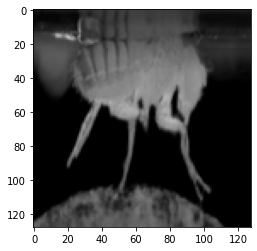

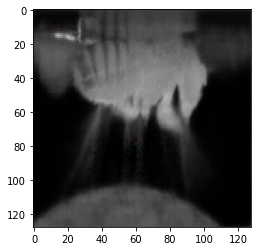

epoch 6 step 10 loss_re_A 0.026458721607923508 loss_kl_A 0.0014372736914083362 loss_re_B 0.03269664943218231 loss_kl_B 0.001547686755657196
epoch 6 step 20 loss_re_A 0.02806168422102928 loss_kl_A 0.010139352641999722 loss_re_B 0.036331161856651306 loss_kl_B 0.010125009343028069
epoch 6 step 30 loss_re_A 0.0261840857565403 loss_kl_A 0.0015051455702632666 loss_re_B 0.032085120677948 loss_kl_B 0.0014976495876908302
epoch 6 step 40 loss_re_A 0.0236385278403759 loss_kl_A 0.0009793936042115092 loss_re_B 0.029697701334953308 loss_kl_B 0.0009725647978484631
learning rate change!
epoch 7 step 0 loss_re_A 0.02264724299311638 loss_kl_A 0.003075187560170889 loss_re_B 0.02946021780371666 loss_kl_B 0.0031674173660576344


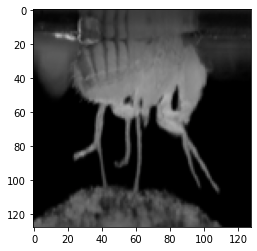

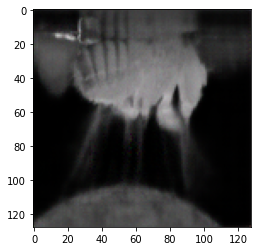

epoch 7 step 10 loss_re_A 0.02217012271285057 loss_kl_A 0.001115672173909843 loss_re_B 0.02913558855652809 loss_kl_B 0.0010972217423841357
epoch 7 step 20 loss_re_A 0.02268839441239834 loss_kl_A 0.0011904177954420447 loss_re_B 0.02904946357011795 loss_kl_B 0.001145950867794454
epoch 7 step 30 loss_re_A 0.023364264518022537 loss_kl_A 0.0008569186902604997 loss_re_B 0.02939864993095398 loss_kl_B 0.0008455706993117929
epoch 7 step 40 loss_re_A 0.02285594493150711 loss_kl_A 0.0009374281507916749 loss_re_B 0.030033309012651443 loss_kl_B 0.0009326754952780902
epoch 8 step 0 loss_re_A 0.021859824657440186 loss_kl_A 0.000903490639757365 loss_re_B 0.0291350856423378 loss_kl_B 0.0008691716357134283


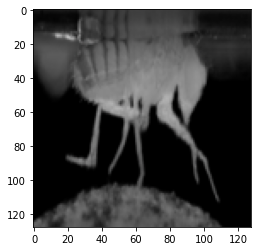

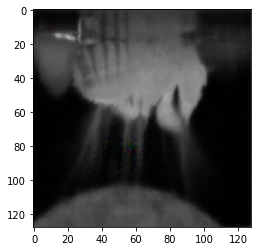

epoch 8 step 10 loss_re_A 0.02207229658961296 loss_kl_A 0.001224174746312201 loss_re_B 0.029614124447107315 loss_kl_B 0.00119272421579808
epoch 8 step 20 loss_re_A 0.022825006395578384 loss_kl_A 0.0010439105099067092 loss_re_B 0.028230253607034683 loss_kl_B 0.0010161286918446422
epoch 8 step 30 loss_re_A 0.022348737344145775 loss_kl_A 0.0008022263064049184 loss_re_B 0.02932860516011715 loss_kl_B 0.0008112728828564286
epoch 8 step 40 loss_re_A 0.02244480699300766 loss_kl_A 0.0009554213029332459 loss_re_B 0.028591757640242577 loss_kl_B 0.0009081187890842557
epoch 9 step 0 loss_re_A 0.022475024685263634 loss_kl_A 0.0010008517419919372 loss_re_B 0.03035537526011467 loss_kl_B 0.000959885714109987


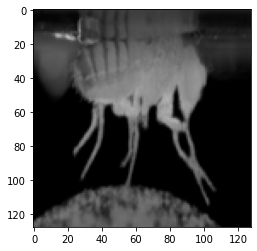

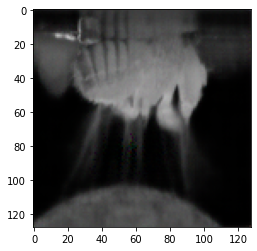

epoch 9 step 10 loss_re_A 0.022781042382121086 loss_kl_A 0.0009246956906281412 loss_re_B 0.030177105218172073 loss_kl_B 0.0009115368011407554
epoch 9 step 20 loss_re_A 0.021231114864349365 loss_kl_A 0.0008499581599608064 loss_re_B 0.028500905260443687 loss_kl_B 0.0008185828919522464
epoch 9 step 30 loss_re_A 0.021800369024276733 loss_kl_A 0.0009091703104786575 loss_re_B 0.02911047264933586 loss_kl_B 0.0008181187440641224
epoch 9 step 40 loss_re_A 0.02224879525601864 loss_kl_A 0.0009495707345195115 loss_re_B 0.029188036918640137 loss_kl_B 0.0008863733964972198
epoch 10 step 0 loss_re_A 0.022157160565257072 loss_kl_A 0.0008203284232877195 loss_re_B 0.02946365997195244 loss_kl_B 0.0008018469670787454


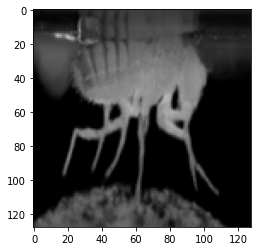

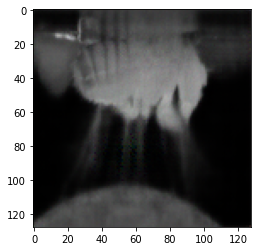

epoch 10 step 10 loss_re_A 0.022724952548742294 loss_kl_A 0.0009460058063268661 loss_re_B 0.028228774666786194 loss_kl_B 0.0009471589000895619
epoch 10 step 20 loss_re_A 0.022481804713606834 loss_kl_A 0.0008306046947836876 loss_re_B 0.02970070205628872 loss_kl_B 0.0008048603194765747
epoch 10 step 30 loss_re_A 0.02287737838923931 loss_kl_A 0.0007677908870391548 loss_re_B 0.028823187574744225 loss_kl_B 0.000754745677113533
epoch 10 step 40 loss_re_A 0.022826295346021652 loss_kl_A 0.0008424088591709733 loss_re_B 0.027717124670743942 loss_kl_B 0.0007740084547549486
epoch 11 step 0 loss_re_A 0.022124823182821274 loss_kl_A 0.0009992601117119193 loss_re_B 0.029840867966413498 loss_kl_B 0.0009094674023799598


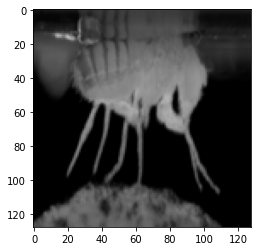

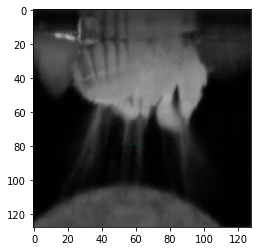

epoch 11 step 10 loss_re_A 0.022536203265190125 loss_kl_A 0.0009961733594536781 loss_re_B 0.028628168627619743 loss_kl_B 0.0009416734683327377
epoch 11 step 20 loss_re_A 0.022415049374103546 loss_kl_A 0.001039072754792869 loss_re_B 0.027235185727477074 loss_kl_B 0.0009159545297734439
epoch 11 step 30 loss_re_A 0.021522827446460724 loss_kl_A 0.0012984040658921003 loss_re_B 0.028931422159075737 loss_kl_B 0.001216912642121315
epoch 11 step 40 loss_re_A 0.022038210183382034 loss_kl_A 0.0012989677488803864 loss_re_B 0.02874663844704628 loss_kl_B 0.0011120995040982962
epoch 12 step 0 loss_re_A 0.022690070793032646 loss_kl_A 0.001083528040908277 loss_re_B 0.026760853826999664 loss_kl_B 0.0008538942784070969


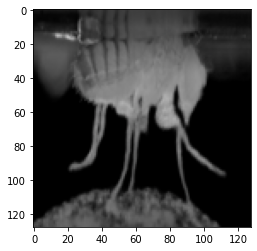

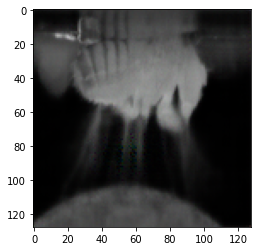

epoch 12 step 10 loss_re_A 0.021579090505838394 loss_kl_A 0.001217025681398809 loss_re_B 0.028174087405204773 loss_kl_B 0.0011623859172686934
epoch 12 step 20 loss_re_A 0.022651072591543198 loss_kl_A 0.0007921583019196987 loss_re_B 0.027783317491412163 loss_kl_B 0.0009604727965779603
epoch 12 step 30 loss_re_A 0.021783702075481415 loss_kl_A 0.000990664935670793 loss_re_B 0.027783220633864403 loss_kl_B 0.0009126810473389924
epoch 12 step 40 loss_re_A 0.021488070487976074 loss_kl_A 0.0012572038685902953 loss_re_B 0.0282838623970747 loss_kl_B 0.0011136755347251892
epoch 13 step 0 loss_re_A 0.021014060825109482 loss_kl_A 0.0010691412026062608 loss_re_B 0.02602851763367653 loss_kl_B 0.0011687305523082614


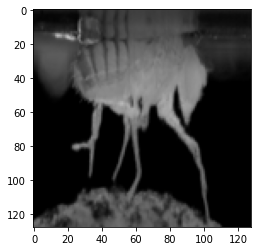

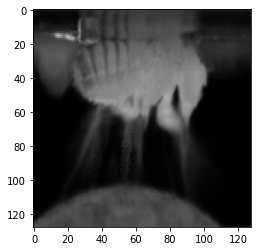

epoch 13 step 10 loss_re_A 0.02211819402873516 loss_kl_A 0.0010793913388624787 loss_re_B 0.026956763118505478 loss_kl_B 0.0010606629075482488
epoch 13 step 20 loss_re_A 0.021268775686621666 loss_kl_A 0.0009789386531338096 loss_re_B 0.027978381142020226 loss_kl_B 0.0008897205698303878
epoch 13 step 30 loss_re_A 0.021758437156677246 loss_kl_A 0.0009830034105107188 loss_re_B 0.0268806591629982 loss_kl_B 0.0011260813334956765
epoch 13 step 40 loss_re_A 0.022752922028303146 loss_kl_A 0.0010992104653269053 loss_re_B 0.026023905724287033 loss_kl_B 0.0011821226216852665
epoch 14 step 0 loss_re_A 0.022717256098985672 loss_kl_A 0.000775553984567523 loss_re_B 0.028236690908670425 loss_kl_B 0.0009394401567988098


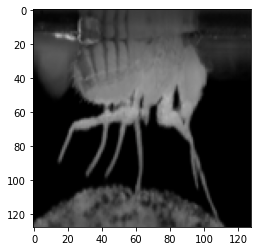

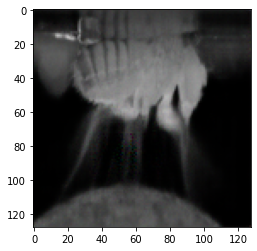

epoch 14 step 10 loss_re_A 0.021556204184889793 loss_kl_A 0.0016333794919773936 loss_re_B 0.02757108025252819 loss_kl_B 0.001284153200685978
epoch 14 step 20 loss_re_A 0.02280288003385067 loss_kl_A 0.0005912937340326607 loss_re_B 0.029182193800807 loss_kl_B 0.0009307367727160454
epoch 14 step 30 loss_re_A 0.02077411860227585 loss_kl_A 0.0018776621436700225 loss_re_B 0.028298942372202873 loss_kl_B 0.0015373051865026355
epoch 14 step 40 loss_re_A 0.02148168347775936 loss_kl_A 0.0025310306809842587 loss_re_B 0.029263099655508995 loss_kl_B 0.002191276988014579
learning rate change!
epoch 15 step 0 loss_re_A 0.0215139240026474 loss_kl_A 0.0009479278814978898 loss_re_B 0.02879418432712555 loss_kl_B 0.0010155938798561692


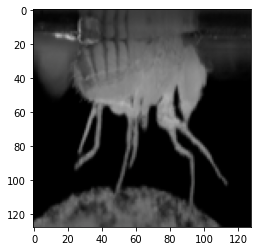

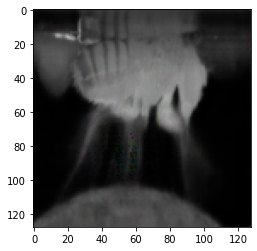

epoch 15 step 10 loss_re_A 0.020388422533869743 loss_kl_A 0.0010941922664642334 loss_re_B 0.027632635086774826 loss_kl_B 0.0010216411901637912
epoch 15 step 20 loss_re_A 0.021978672593832016 loss_kl_A 0.0009108750382438302 loss_re_B 0.024531546980142593 loss_kl_B 0.0010385708883404732
epoch 15 step 30 loss_re_A 0.020631888881325722 loss_kl_A 0.0010245407465845346 loss_re_B 0.026116512715816498 loss_kl_B 0.0009083137265406549
epoch 15 step 40 loss_re_A 0.021965693682432175 loss_kl_A 0.0009287350112572312 loss_re_B 0.02500395104289055 loss_kl_B 0.0009147044620476663
epoch 16 step 0 loss_re_A 0.02133745700120926 loss_kl_A 0.0011750790290534496 loss_re_B 0.026577088981866837 loss_kl_B 0.001297539914958179


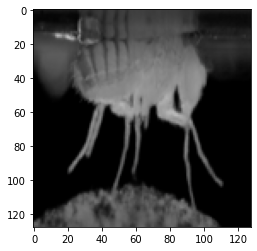

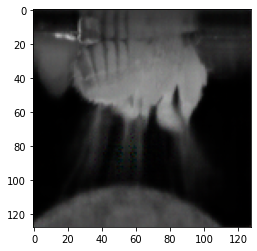

epoch 16 step 10 loss_re_A 0.020963309332728386 loss_kl_A 0.0009790342301130295 loss_re_B 0.02646883949637413 loss_kl_B 0.0010278740664944053
epoch 16 step 20 loss_re_A 0.021311556920409203 loss_kl_A 0.0010327795753255486 loss_re_B 0.023411016911268234 loss_kl_B 0.0010255174711346626
epoch 16 step 30 loss_re_A 0.02115596830844879 loss_kl_A 0.000855674035847187 loss_re_B 0.0246086698025465 loss_kl_B 0.0011132702929899096
epoch 16 step 40 loss_re_A 0.021248850971460342 loss_kl_A 0.001086538308300078 loss_re_B 0.025462154299020767 loss_kl_B 0.0010098167695105076
epoch 17 step 0 loss_re_A 0.021931370720267296 loss_kl_A 0.0010408504167571664 loss_re_B 0.024803634732961655 loss_kl_B 0.0009406983735971153


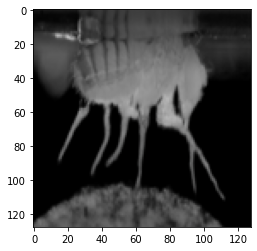

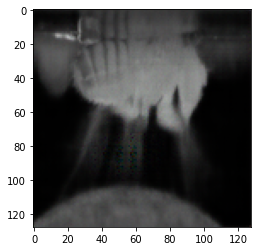

epoch 17 step 10 loss_re_A 0.02088148519396782 loss_kl_A 0.0010589751182124019 loss_re_B 0.025828277692198753 loss_kl_B 0.0011121315183117986
epoch 17 step 20 loss_re_A 0.0219697467982769 loss_kl_A 0.0010103185195475817 loss_re_B 0.02659456431865692 loss_kl_B 0.0009669174323789775
epoch 17 step 30 loss_re_A 0.02146541140973568 loss_kl_A 0.0010161370737478137 loss_re_B 0.024420231580734253 loss_kl_B 0.001064001815393567
epoch 17 step 40 loss_re_A 0.019908133894205093 loss_kl_A 0.0011902678525075316 loss_re_B 0.026261745020747185 loss_kl_B 0.0012448237976059318
epoch 18 step 0 loss_re_A 0.0210221316665411 loss_kl_A 0.0015898224664852023 loss_re_B 0.025838341563940048 loss_kl_B 0.0013044057413935661


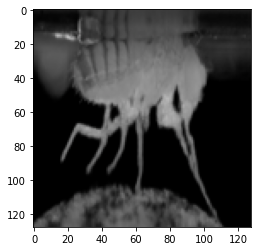

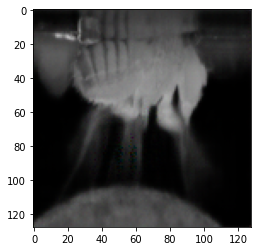

epoch 18 step 10 loss_re_A 0.021866288036108017 loss_kl_A 0.0009371397900395095 loss_re_B 0.024047231301665306 loss_kl_B 0.0011830412549898028
epoch 18 step 20 loss_re_A 0.021123938262462616 loss_kl_A 0.0011835454497486353 loss_re_B 0.026087686419487 loss_kl_B 0.0009695863700471818
epoch 18 step 30 loss_re_A 0.02239949256181717 loss_kl_A 0.0009136215085163713 loss_re_B 0.026529978960752487 loss_kl_B 0.000917664379812777
epoch 18 step 40 loss_re_A 0.022164996713399887 loss_kl_A 0.0011924559948965907 loss_re_B 0.025520626455545425 loss_kl_B 0.0010620768880471587
epoch 19 step 0 loss_re_A 0.02079400047659874 loss_kl_A 0.0011049205204471946 loss_re_B 0.02502528391778469 loss_kl_B 0.0011292373528704047


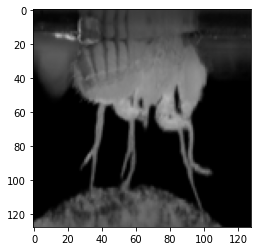

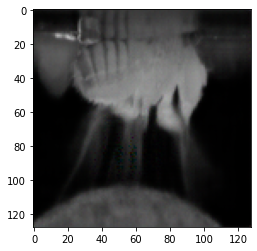

epoch 19 step 10 loss_re_A 0.02153969369828701 loss_kl_A 0.0010480047203600407 loss_re_B 0.022339170798659325 loss_kl_B 0.0012190239503979683
epoch 19 step 20 loss_re_A 0.020361600443720818 loss_kl_A 0.0010027264943346381 loss_re_B 0.02364562824368477 loss_kl_B 0.001077737077139318
epoch 19 step 30 loss_re_A 0.021357804536819458 loss_kl_A 0.0008781414362601936 loss_re_B 0.026126142591238022 loss_kl_B 0.0009022317826747894
epoch 19 step 40 loss_re_A 0.021532829850912094 loss_kl_A 0.000872658216394484 loss_re_B 0.02473929338157177 loss_kl_B 0.001092446269467473
epoch 20 step 0 loss_re_A 0.021257540211081505 loss_kl_A 0.0009253487223759294 loss_re_B 0.02557201310992241 loss_kl_B 0.0010872742859646678


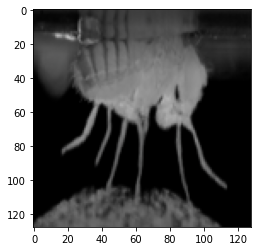

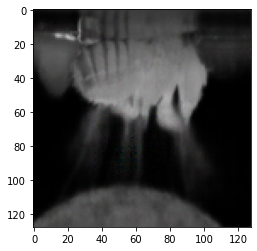

epoch 20 step 10 loss_re_A 0.020156534388661385 loss_kl_A 0.0009056813432835042 loss_re_B 0.024994876235723495 loss_kl_B 0.0010876652086153626
epoch 20 step 20 loss_re_A 0.021471550688147545 loss_kl_A 0.000991486362181604 loss_re_B 0.025743989273905754 loss_kl_B 0.0011167064076289535
epoch 20 step 30 loss_re_A 0.020310334861278534 loss_kl_A 0.00103973806835711 loss_re_B 0.023635033518075943 loss_kl_B 0.0012126723304390907
epoch 20 step 40 loss_re_A 0.020592596381902695 loss_kl_A 0.0011094146175310016 loss_re_B 0.0249059796333313 loss_kl_B 0.0010544505203142762
epoch 21 step 0 loss_re_A 0.020428935065865517 loss_kl_A 0.0012154245050624013 loss_re_B 0.024832259863615036 loss_kl_B 0.001127645024098456


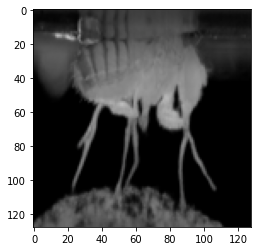

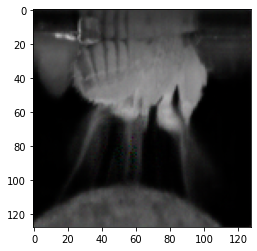

epoch 21 step 10 loss_re_A 0.021209102123975754 loss_kl_A 0.0011042424011975527 loss_re_B 0.02475675567984581 loss_kl_B 0.0010791292879730463
epoch 21 step 20 loss_re_A 0.020845897495746613 loss_kl_A 0.0010362338507547975 loss_re_B 0.024641796946525574 loss_kl_B 0.001112667960114777
epoch 21 step 30 loss_re_A 0.021044712513685226 loss_kl_A 0.00108559790533036 loss_re_B 0.026191186159849167 loss_kl_B 0.0010209400206804276
epoch 21 step 40 loss_re_A 0.021116461604833603 loss_kl_A 0.001006655627861619 loss_re_B 0.023460259661078453 loss_kl_B 0.001094912993721664
epoch 22 step 0 loss_re_A 0.021614830940961838 loss_kl_A 0.0006708409055136144 loss_re_B 0.022646641358733177 loss_kl_B 0.0013297488912940025


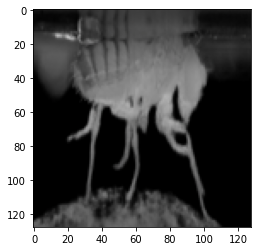

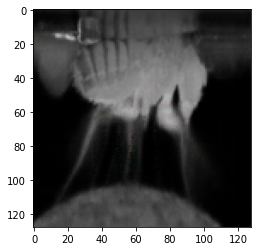

epoch 22 step 10 loss_re_A 0.019831988960504532 loss_kl_A 0.0010233698412775993 loss_re_B 0.023061862215399742 loss_kl_B 0.001103753107599914
epoch 22 step 20 loss_re_A 0.020440883934497833 loss_kl_A 0.0010213105706498027 loss_re_B 0.025409627705812454 loss_kl_B 0.0010353232501074672
epoch 22 step 30 loss_re_A 0.021081147715449333 loss_kl_A 0.0010835727443918586 loss_re_B 0.0245228074491024 loss_kl_B 0.0011403464013710618
epoch 22 step 40 loss_re_A 0.02101542055606842 loss_kl_A 0.0010129977017641068 loss_re_B 0.022936835885047913 loss_kl_B 0.001040649483911693
learning rate change!
epoch 23 step 0 loss_re_A 0.020056424662470818 loss_kl_A 0.0011332659050822258 loss_re_B 0.025483397766947746 loss_kl_B 0.0011732245329767466


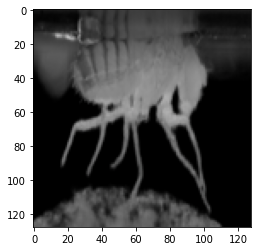

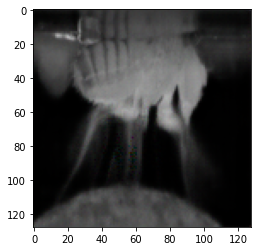

epoch 23 step 10 loss_re_A 0.02137499302625656 loss_kl_A 0.0009274285403080285 loss_re_B 0.023869579657912254 loss_kl_B 0.001081137335859239
epoch 23 step 20 loss_re_A 0.020142812281847 loss_kl_A 0.0010971088195219636 loss_re_B 0.024829331785440445 loss_kl_B 0.0010480181081220508
epoch 23 step 30 loss_re_A 0.02167811058461666 loss_kl_A 0.001078585279174149 loss_re_B 0.025832993909716606 loss_kl_B 0.0010019107721745968
epoch 23 step 40 loss_re_A 0.020732741802930832 loss_kl_A 0.0009873727103695273 loss_re_B 0.025491908192634583 loss_kl_B 0.0010771035449579358
epoch 24 step 0 loss_re_A 0.020702091977000237 loss_kl_A 0.001086031086742878 loss_re_B 0.02141101285815239 loss_kl_B 0.0012264857068657875


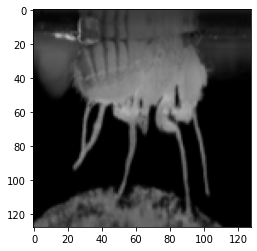

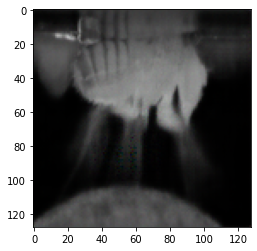

epoch 24 step 10 loss_re_A 0.0213923417031765 loss_kl_A 0.0010497084585949779 loss_re_B 0.0255047008395195 loss_kl_B 0.0011276764562353492
epoch 24 step 20 loss_re_A 0.019887341186404228 loss_kl_A 0.000986110302619636 loss_re_B 0.02139631286263466 loss_kl_B 0.0011376626789569855
epoch 24 step 30 loss_re_A 0.020388653501868248 loss_kl_A 0.0010557422647252679 loss_re_B 0.021672897040843964 loss_kl_B 0.0012373948702588677
epoch 24 step 40 loss_re_A 0.020665377378463745 loss_kl_A 0.0009310475434176624 loss_re_B 0.02284364216029644 loss_kl_B 0.001004083314910531
epoch 25 step 0 loss_re_A 0.021393876522779465 loss_kl_A 0.0009612203575670719 loss_re_B 0.02451874315738678 loss_kl_B 0.0010794560657814145


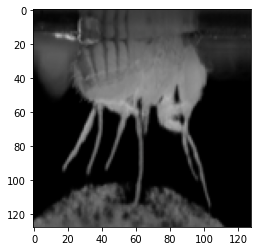

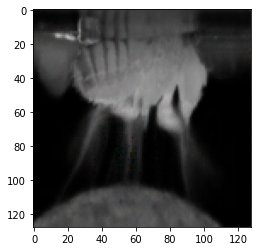

epoch 25 step 10 loss_re_A 0.02073003351688385 loss_kl_A 0.0010271786013618112 loss_re_B 0.021096184849739075 loss_kl_B 0.001226494088768959
epoch 25 step 20 loss_re_A 0.021384280174970627 loss_kl_A 0.0010559118818491697 loss_re_B 0.02550230734050274 loss_kl_B 0.0010634204372763634
epoch 25 step 30 loss_re_A 0.020326372236013412 loss_kl_A 0.001042911666445434 loss_re_B 0.02384893223643303 loss_kl_B 0.0011486123548820615
epoch 25 step 40 loss_re_A 0.019967298954725266 loss_kl_A 0.0011415717890486121 loss_re_B 0.022511783987283707 loss_kl_B 0.001251816633157432
epoch 26 step 0 loss_re_A 0.02242635190486908 loss_kl_A 0.0009859846904873848 loss_re_B 0.023761816322803497 loss_kl_B 0.0010949227726086974


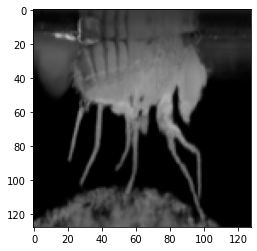

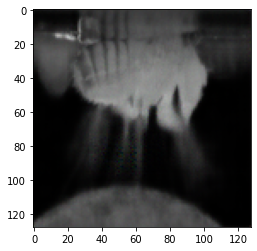

epoch 26 step 10 loss_re_A 0.02059253677725792 loss_kl_A 0.0010545006953179836 loss_re_B 0.022438418120145798 loss_kl_B 0.0012041968293488026
epoch 26 step 20 loss_re_A 0.020785033702850342 loss_kl_A 0.0009602762875147164 loss_re_B 0.02183900773525238 loss_kl_B 0.001164884539321065
epoch 26 step 30 loss_re_A 0.020970001816749573 loss_kl_A 0.0011068612802773714 loss_re_B 0.022677674889564514 loss_kl_B 0.001288968720473349
epoch 26 step 40 loss_re_A 0.02095942199230194 loss_kl_A 0.0009126087534241378 loss_re_B 0.022484904155135155 loss_kl_B 0.00109831930603832
epoch 27 step 0 loss_re_A 0.020800694823265076 loss_kl_A 0.0008933208882808685 loss_re_B 0.024460744112730026 loss_kl_B 0.001063769101165235


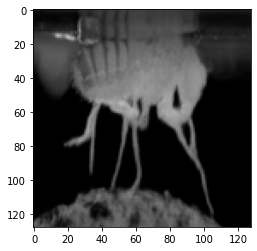

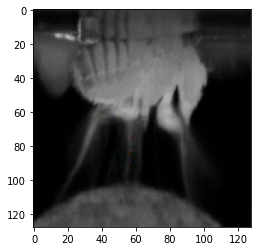

epoch 27 step 10 loss_re_A 0.01976749673485756 loss_kl_A 0.0010496132308617234 loss_re_B 0.023307207971811295 loss_kl_B 0.0009725007112137973
epoch 27 step 20 loss_re_A 0.021314769983291626 loss_kl_A 0.001195289078168571 loss_re_B 0.02452849969267845 loss_kl_B 0.0011471286416053772
epoch 27 step 30 loss_re_A 0.02044888585805893 loss_kl_A 0.0011609607608988881 loss_re_B 0.022711127996444702 loss_kl_B 0.001244983053766191
epoch 27 step 40 loss_re_A 0.019344007596373558 loss_kl_A 0.0010843222262337804 loss_re_B 0.025159131735563278 loss_kl_B 0.0010757552227005363
epoch 28 step 0 loss_re_A 0.020824123173952103 loss_kl_A 0.001056366483680904 loss_re_B 0.02492792159318924 loss_kl_B 0.0010662729619070888


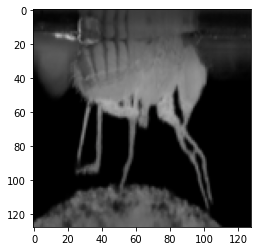

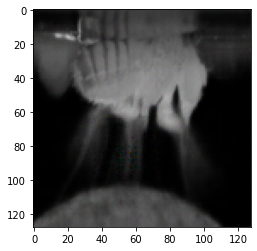

epoch 28 step 10 loss_re_A 0.020502159371972084 loss_kl_A 0.0010090972064062953 loss_re_B 0.023111943155527115 loss_kl_B 0.0011358432238921523
epoch 28 step 20 loss_re_A 0.019919170066714287 loss_kl_A 0.0010156389325857162 loss_re_B 0.02380008064210415 loss_kl_B 0.0010493717854842544
epoch 28 step 30 loss_re_A 0.021059006452560425 loss_kl_A 0.000979598262347281 loss_re_B 0.022336279973387718 loss_kl_B 0.0010604106355458498
epoch 28 step 40 loss_re_A 0.020465940237045288 loss_kl_A 0.0010635427897796035 loss_re_B 0.023639528080821037 loss_kl_B 0.001132627367042005
epoch 29 step 0 loss_re_A 0.02088840864598751 loss_kl_A 0.0009314282215200365 loss_re_B 0.024902796372771263 loss_kl_B 0.0009731546160764992


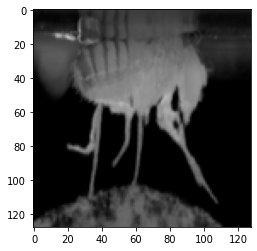

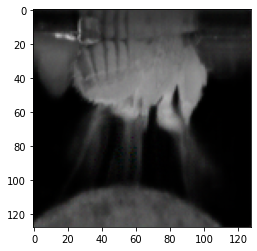

epoch 29 step 10 loss_re_A 0.020355867221951485 loss_kl_A 0.0010997963836416602 loss_re_B 0.023963529616594315 loss_kl_B 0.0011027370346710086
epoch 29 step 20 loss_re_A 0.020913638174533844 loss_kl_A 0.000872075033839792 loss_re_B 0.023783987388014793 loss_kl_B 0.0010607435833662748
epoch 29 step 30 loss_re_A 0.02050718478858471 loss_kl_A 0.0010617970256134868 loss_re_B 0.02404017373919487 loss_kl_B 0.0010997856734320521
epoch 29 step 40 loss_re_A 0.02038225345313549 loss_kl_A 0.0009464967879466712 loss_re_B 0.02150711789727211 loss_kl_B 0.001150541822426021
epoch 30 step 0 loss_re_A 0.020739950239658356 loss_kl_A 0.0010837826412171125 loss_re_B 0.023937072604894638 loss_kl_B 0.0011595693649724126


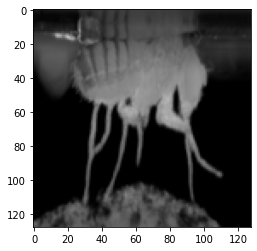

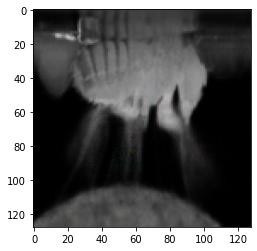

epoch 30 step 10 loss_re_A 0.019806556403636932 loss_kl_A 0.001095385174266994 loss_re_B 0.025271011516451836 loss_kl_B 0.0010445042280480266
epoch 30 step 20 loss_re_A 0.019749848172068596 loss_kl_A 0.0009114636341109872 loss_re_B 0.023878417909145355 loss_kl_B 0.0010539202485233545
epoch 30 step 30 loss_re_A 0.021799130365252495 loss_kl_A 0.0010518314084038138 loss_re_B 0.02469305321574211 loss_kl_B 0.0010918345069512725
epoch 30 step 40 loss_re_A 0.020790956914424896 loss_kl_A 0.0009960690513253212 loss_re_B 0.024379556998610497 loss_kl_B 0.0011605856707319617
learning rate change!
epoch 31 step 0 loss_re_A 0.020203668624162674 loss_kl_A 0.0010568430880084634 loss_re_B 0.025053150951862335 loss_kl_B 0.0009439396671950817


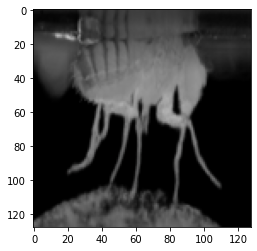

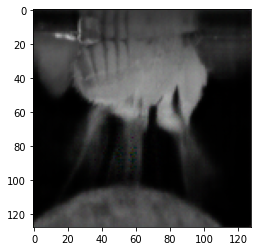

epoch 31 step 10 loss_re_A 0.020661409944295883 loss_kl_A 0.0009182440117001534 loss_re_B 0.020694587379693985 loss_kl_B 0.001127277035266161
epoch 31 step 20 loss_re_A 0.020781708881258965 loss_kl_A 0.0010060964850708842 loss_re_B 0.025292929261922836 loss_kl_B 0.0008740243501961231
epoch 31 step 30 loss_re_A 0.02078983560204506 loss_kl_A 0.0010005742078647017 loss_re_B 0.023663684725761414 loss_kl_B 0.0009624636149965227
epoch 31 step 40 loss_re_A 0.020176364108920097 loss_kl_A 0.0010301187867298722 loss_re_B 0.024850472807884216 loss_kl_B 0.0010564897675067186
epoch 32 step 0 loss_re_A 0.020948564633727074 loss_kl_A 0.001037909067235887 loss_re_B 0.023500654846429825 loss_kl_B 0.0011960359988734126


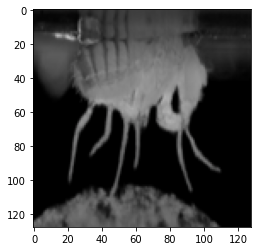

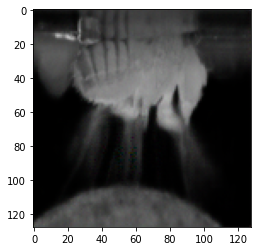

epoch 32 step 10 loss_re_A 0.020527394488453865 loss_kl_A 0.0009131451952271163 loss_re_B 0.024309616535902023 loss_kl_B 0.0011463540140539408
epoch 32 step 20 loss_re_A 0.020210914313793182 loss_kl_A 0.0009391267085447907 loss_re_B 0.0232095867395401 loss_kl_B 0.0011176442494615912
epoch 32 step 30 loss_re_A 0.021542144939303398 loss_kl_A 0.0009624841040931642 loss_re_B 0.022804124280810356 loss_kl_B 0.0010266334284096956
epoch 32 step 40 loss_re_A 0.021177789196372032 loss_kl_A 0.0010913823498412967 loss_re_B 0.024928420782089233 loss_kl_B 0.0010919998167082667
epoch 33 step 0 loss_re_A 0.01997200958430767 loss_kl_A 0.001001021359115839 loss_re_B 0.02111269161105156 loss_kl_B 0.0011119451373815536


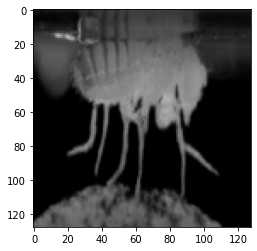

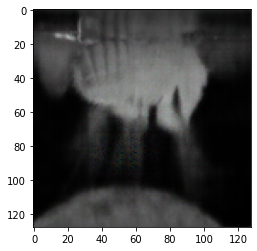

epoch 33 step 10 loss_re_A 0.021306224167346954 loss_kl_A 0.0010620305547490716 loss_re_B 0.02293504774570465 loss_kl_B 0.0010997537756338716
epoch 33 step 20 loss_re_A 0.020518459379673004 loss_kl_A 0.0010715780081227422 loss_re_B 0.021683216094970703 loss_kl_B 0.0011253510601818562
epoch 33 step 30 loss_re_A 0.020228995010256767 loss_kl_A 0.0010309892240911722 loss_re_B 0.02358759194612503 loss_kl_B 0.0011948425089940429
epoch 33 step 40 loss_re_A 0.020069509744644165 loss_kl_A 0.0010928420815616846 loss_re_B 0.023839203640818596 loss_kl_B 0.0010229147737845778
epoch 34 step 0 loss_re_A 0.020252641290426254 loss_kl_A 0.001015881192870438 loss_re_B 0.02475881576538086 loss_kl_B 0.0009751336765475571


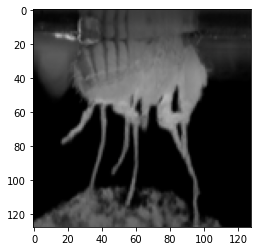

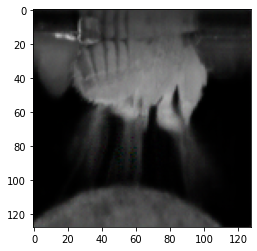

epoch 34 step 10 loss_re_A 0.020057670772075653 loss_kl_A 0.001106208423152566 loss_re_B 0.022927697747945786 loss_kl_B 0.0010821976466104388
epoch 34 step 20 loss_re_A 0.020927533507347107 loss_kl_A 0.0009599439799785614 loss_re_B 0.023477768525481224 loss_kl_B 0.001334590488113463
epoch 34 step 30 loss_re_A 0.019892221316695213 loss_kl_A 0.0010198683012276888 loss_re_B 0.022571876645088196 loss_kl_B 0.001176938065327704
epoch 34 step 40 loss_re_A 0.019493289291858673 loss_kl_A 0.0010334525723010302 loss_re_B 0.02286071702837944 loss_kl_B 0.0011594388633966446
epoch 35 step 0 loss_re_A 0.020732691511511803 loss_kl_A 0.001078785047866404 loss_re_B 0.02591782808303833 loss_kl_B 0.0010977692436426878


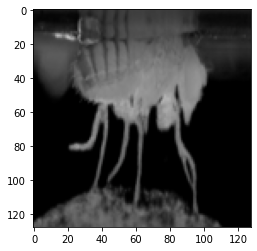

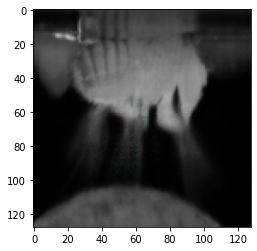

epoch 35 step 10 loss_re_A 0.020367080345749855 loss_kl_A 0.001031546271406114 loss_re_B 0.021601570770144463 loss_kl_B 0.0012249232968315482
epoch 35 step 20 loss_re_A 0.02097654901444912 loss_kl_A 0.0010215907823294401 loss_re_B 0.022535359486937523 loss_kl_B 0.0011738663306459785
epoch 35 step 30 loss_re_A 0.02052593044936657 loss_kl_A 0.0010308882920071483 loss_re_B 0.022380322217941284 loss_kl_B 0.0012315807398408651
epoch 35 step 40 loss_re_A 0.020259089767932892 loss_kl_A 0.0009449615026824176 loss_re_B 0.020960386842489243 loss_kl_B 0.0011557388352230191
epoch 36 step 0 loss_re_A 0.020526885986328125 loss_kl_A 0.0010076246690005064 loss_re_B 0.023168031126260757 loss_kl_B 0.0009736604988574982


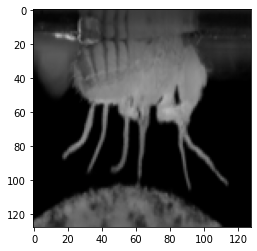

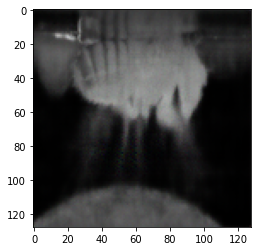

epoch 36 step 10 loss_re_A 0.01989930123090744 loss_kl_A 0.0010368943912908435 loss_re_B 0.022342368960380554 loss_kl_B 0.0010545281693339348
epoch 36 step 20 loss_re_A 0.019582821056246758 loss_kl_A 0.0009373290813528001 loss_re_B 0.022116299718618393 loss_kl_B 0.0010537125635892153
epoch 36 step 30 loss_re_A 0.021201711148023605 loss_kl_A 0.000943198159802705 loss_re_B 0.023919548839330673 loss_kl_B 0.0012058906722813845
epoch 36 step 40 loss_re_A 0.020462315529584885 loss_kl_A 0.0010508496779948473 loss_re_B 0.02514706924557686 loss_kl_B 0.001079356181435287
epoch 37 step 0 loss_re_A 0.020689673721790314 loss_kl_A 0.0009999036556109786 loss_re_B 0.021549411118030548 loss_kl_B 0.0012630615383386612


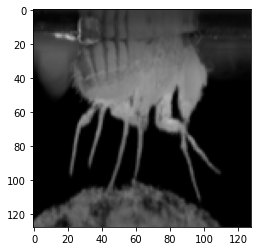

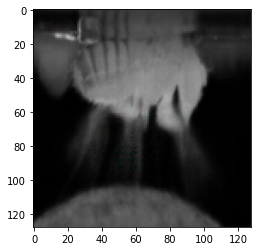

epoch 37 step 10 loss_re_A 0.020562995225191116 loss_kl_A 0.0009732210892252624 loss_re_B 0.02206329070031643 loss_kl_B 0.001162685570307076
epoch 37 step 20 loss_re_A 0.02002580091357231 loss_kl_A 0.0010360227897763252 loss_re_B 0.023153549060225487 loss_kl_B 0.0010908972471952438
epoch 37 step 30 loss_re_A 0.020164866000413895 loss_kl_A 0.0010468092514201999 loss_re_B 0.02414879761636257 loss_kl_B 0.0011147415498271585
epoch 37 step 40 loss_re_A 0.019944701343774796 loss_kl_A 0.0011396546615287662 loss_re_B 0.020826704800128937 loss_kl_B 0.001191147486679256
epoch 38 step 0 loss_re_A 0.02068037912249565 loss_kl_A 0.0009424933232367039 loss_re_B 0.02476619742810726 loss_kl_B 0.0010539842769503593


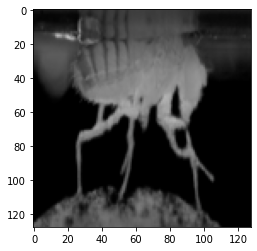

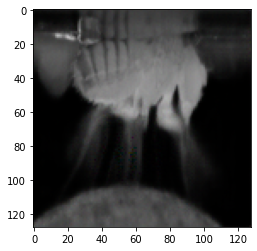

epoch 38 step 10 loss_re_A 0.02053002081811428 loss_kl_A 0.0011014232877641916 loss_re_B 0.022074993699789047 loss_kl_B 0.0011878329096361995
epoch 38 step 20 loss_re_A 0.020212918519973755 loss_kl_A 0.000976747483946383 loss_re_B 0.022641902789473534 loss_kl_B 0.0011578610865399241
epoch 38 step 30 loss_re_A 0.020921727642416954 loss_kl_A 0.0010671628406271338 loss_re_B 0.020900368690490723 loss_kl_B 0.0012347068404778838
epoch 38 step 40 loss_re_A 0.019847718998789787 loss_kl_A 0.0010386706562712789 loss_re_B 0.02257349155843258 loss_kl_B 0.0010836400324478745
learning rate change!
epoch 39 step 0 loss_re_A 0.02041347697377205 loss_kl_A 0.000947138003539294 loss_re_B 0.02353888377547264 loss_kl_B 0.0010695151286199689


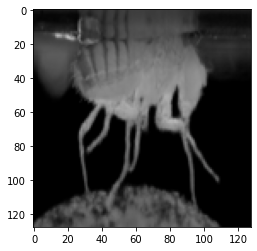

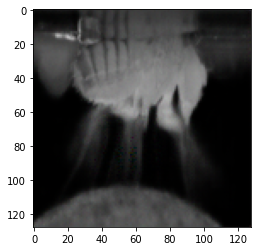

epoch 39 step 10 loss_re_A 0.02081219106912613 loss_kl_A 0.0009896729607135057 loss_re_B 0.023507293313741684 loss_kl_B 0.0009720256784930825
epoch 39 step 20 loss_re_A 0.02015511691570282 loss_kl_A 0.0010776026174426079 loss_re_B 0.022756977006793022 loss_kl_B 0.0011608892818912864
epoch 39 step 30 loss_re_A 0.020446397364139557 loss_kl_A 0.0009562054765410721 loss_re_B 0.02206287905573845 loss_kl_B 0.0010494375601410866
epoch 39 step 40 loss_re_A 0.02102253958582878 loss_kl_A 0.0010187224252149463 loss_re_B 0.023645639419555664 loss_kl_B 0.0009851614013314247


In [39]:
# Initialize the networks
vae = VAE(zsize=512).cuda()

# Initialize the optimizers
lr = 0.0005
vae_optimizer = optim.Adam(vae.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-5)

train_epoch = 40
# For storing results
rec_loss_A = []
rec_loss_B = []
kl_loss_A = []
kl_loss_B = []

for epoch in range(train_epoch):
    vae.train()

    if (epoch + 1) % 8 == 0:
        vae_optimizer.param_groups[0]['lr'] /= 4
        print("learning rate change!")

    for i, data in enumerate(dataloader):
        vae.train()
        vae.zero_grad()
        
        img_A = data['A'].cuda()
        img_B = data['B'].cuda()

        # The embeddings
        rec_A, mu_A, logvar_A = vae(img_A)
        rec_B, mu_B, logvar_B = vae(img_B)

        # The loss function --------------------------------------------------------------------------------

        loss_re_A, loss_kl_A = loss_function(rec_A, img_A, mu_A, logvar_A)
        loss_re_B, loss_kl_B = loss_function(rec_B, img_B, mu_B, logvar_B)

        # ---------------------------------------------------------------------------------------------------

        # Backward 
        (loss_re_A + loss_kl_A + loss_re_B + loss_kl_B).backward()
        vae_optimizer.step()

        # Store values --------------------------------------------------------------------------------------

        rec_loss_A += [loss_re_A.item()]
        rec_loss_B += [loss_re_B.item()]
        kl_loss_A += [loss_kl_A.item()]
        kl_loss_B += [loss_kl_B.item()]

        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 10 == 0:
            print('epoch', epoch, 'step', i,
                  'loss_re_A', loss_re_A.item(), 'loss_kl_A', loss_kl_A.item(), 
                  'loss_re_B', loss_re_B.item(), 'loss_kl_B', loss_kl_B.item())

        if i % 50 == 0:
            visualize(img_A[0].cpu())
            visualize(rec_A[0].detach().cpu())

        if i % 10000 == 0 and i != 0:
            break

## Results

In [40]:
def smooth(list):
  return signal.savgol_filter(list, 101, 3)

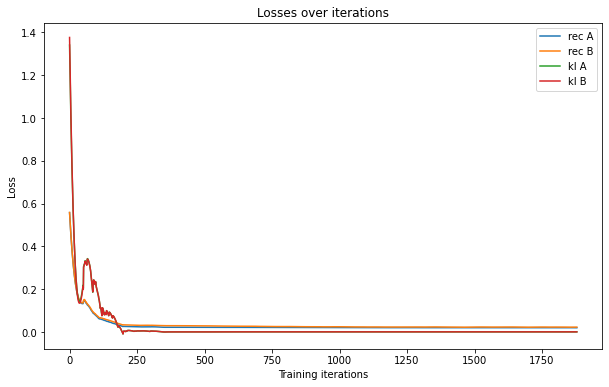

In [41]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(smooth(rec_loss_A))
plt.plot(smooth(rec_loss_B))
plt.plot(smooth(kl_loss_A))
plt.plot(smooth(kl_loss_B))
plt.legend(['rec A', 'rec B', 'kl A', 'kl B'])
plt.show()

In [43]:
torch.save(vae.state_dict(), '/content/vae')

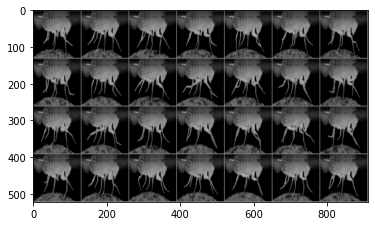

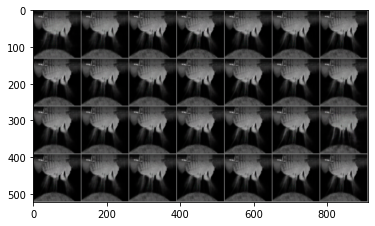

In [48]:
visualize(make_grid(img_A.cpu(), nrow=7))
visualize(make_grid(rec_A.detach().cpu(), nrow=7))

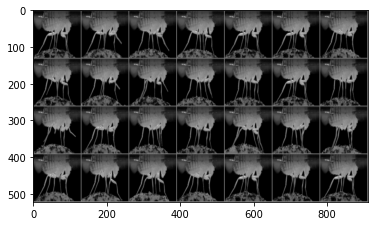

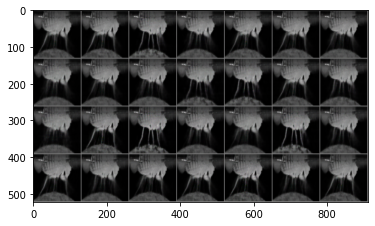

In [49]:
visualize(make_grid(img_B.cpu(), nrow=7))
visualize(make_grid(rec_B.detach().cpu(), nrow=7))